## Lab2 Classification

1. 数据探索：理解每个属性的分布，或基本描述统计
2. 数据清洗：未知值处理。提交构建好的新的训练集、测试集文件
3. 模型选择
* 至少选择3种分类算法进行模型对比
* 使用K折交叉检验，K的数值可以自行设置
* 使用多种评价指标
* 保存分类结果
* 模型优化：特征选择、参数调节
4. 结果分析
* 生成模型性能对比表格，绘制性能对比图
* 分析性能优劣原因，案例分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")
pd.options.display.latex.repr = True

# 数据探索EDA

阅读 `adult.names` 可以得到完整的对于数据集及任务的描述。

数据集共含有14个属性，1个类别属性，48842条记录（随机按照2:1比例分割，分别存于 `adult.data` 和 `adult.test` 中），3620条记录含有缺失值，处理为"?"。

类别揭示实例的收入，共2类（`>50k`,`<=50k`），比例大致为1:3.

14个属性中，离散的属性为

> 2.workclass;  4.education;  6.marital-status;  7.occupation;  8.relationship;  9.race;  10.sex;   14.native-country.

连续的属性为

> 1.age;  3.fnlwgt;  5.education-num;  11.capital-gain;  12.capital-loss;  13.hours-per-week;

大多数的属性都是字面意思。`fnlwgt` 解释为一种权重值，某些人口统计学特征相近的记录有相近的`fnlwgt`，但是此规律仅在同一州内生效。

## 读取数据

In [2]:
columns = ['age','workClass','fnlwgt','education','educationNum','martialStatus','occupation','relationship','race','sex','capitalGain','capitalLoss','hoursPerWeek','nativeCountry','income']
train = pd.read_csv('./data/adult.data',header=None,names=columns) # 源数据没有字段行
test = pd.read_csv('./data/adult.test',header=None,names=columns,skiprows=1) # 源数据第一行不是记录
data = pd.concat([train,test])
display(data.tail(3).iloc[:,:6],
        data.tail(3).iloc[:,6:10],
        data.tail(3).iloc[:,10:])

,age,workClass,fnlwgt,education,educationNum,martialStatus
16278,38,Private,374983,Bachelors,13,Married-civ-spouse
16279,44,Private,83891,Bachelors,13,Divorced
16280,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse


,occupation,relationship,race,sex
16278,Prof-specialty,Husband,White,Male
16279,Adm-clerical,Own-child,Asian-Pac-Islander,Male
16280,Exec-managerial,Husband,White,Male


,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
16278,0,0,50,United-States,<=50K.
16279,5455,0,40,United-States,<=50K.
16280,0,0,60,United-States,>50K.


## 描述性统计

In [3]:
display(train.iloc[:,[1,3,5,6,7,8,9,13,14]].describe().iloc[:,:4],
        train.iloc[:,[1,3,5,6,7,8,9,13,14]].describe().iloc[:,4:],
        test.iloc[:,[1,3,5,6,7,8,9,13,14]].describe().iloc[:,0:4],
        test.iloc[:,[1,3,5,6,7,8,9,13,14]].describe().iloc[:,4:])

,workClass,education,martialStatus,occupation
count,32561,32561,32561,32561
unique,9,16,7,15
top,Private,HS-grad,Married-civ-spouse,Prof-specialty
freq,22696,10501,14976,4140


,relationship,race,sex,nativeCountry,income
count,32561,32561,32561,32561,32561
unique,6,5,2,42,2
top,Husband,White,Male,United-States,<=50K
freq,13193,27816,21790,29170,24720


,workClass,education,martialStatus,occupation
count,16281,16281,16281,16281
unique,9,16,7,15
top,Private,HS-grad,Married-civ-spouse,Prof-specialty
freq,11210,5283,7403,2032


,relationship,race,sex,nativeCountry,income
count,16281,16281,16281,16281,16281
unique,6,5,2,41,2
top,Husband,White,Male,United-States,<=50K.
freq,6523,13946,10860,14662,12435


**注意：离散属性的unique值包含了"?"，缺失值**

**要点1：test数据集中，两种标签分别比train多了句号**

> 下一步处理方案： $>50K. \rightarrow >50K; \ <=50K. \rightarrow <=50K$ 

In [4]:
display(train.iloc[:,[0,2,4,10,11,12]].describe().round(2)) #连续型数据
display(test.iloc[:,[0,2,4,10,11,12]].describe().round(2)) #连续型数据

,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek
count,32561.00,32561.00,32561.00,32561.00,32561.00,32561.00
mean,38.58,189778.37,10.08,1077.65,87.30,40.44
std,13.64,105549.98,2.57,7385.29,402.96,12.35
min,17.00,12285.00,1.00,0.00,0.00,1.00
25%,28.00,117827.00,9.00,0.00,0.00,40.00
50%,37.00,178356.00,10.00,0.00,0.00,40.00
75%,48.00,237051.00,12.00,0.00,0.00,45.00
max,90.00,1484705.00,16.00,99999.00,4356.00,99.00


,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek
count,16281.00,16281.00,16281.00,16281.00,16281.00,16281.00
mean,38.77,189435.68,10.07,1081.91,87.90,40.39
std,13.85,105714.91,2.57,7583.94,403.11,12.48
min,17.00,13492.00,1.00,0.00,0.00,1.00
25%,28.00,116736.00,9.00,0.00,0.00,40.00
50%,37.00,177831.00,10.00,0.00,0.00,40.00
75%,48.00,238384.00,12.00,0.00,0.00,45.00
max,90.00,1490400.00,16.00,99999.00,3770.00,99.00


**要点2：`capitalGain`、`capitalLoss`超过75%的记录同为0。`nativeCountry`近90%记录为United-States。**

> 下一步处理：为某一值的样本较多，可以考虑较少类别的离散化。

## 个别属性理解

In [5]:
data.groupby(by=['fnlwgt']).count().iloc[:,0].sort_values(ascending=False).max()

21

(0.0, 700000.0)

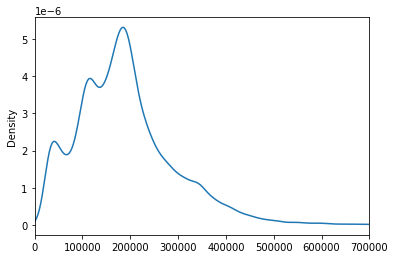

In [6]:
ax = data.fnlwgt.plot.kde()
ax.set_xlim([0,700000])

**要点3：很多网上的分析把fnlwgt解读为id序号，实际上并不是（因为这里可以看到不唯一）。fnlwgt值有一定的分布规律。考虑数据集的解读，fnlwgt和部分人口统计学特征有重复表达，另外，根据说明，该值仅在同一州内具有可比性，而我们缺失了州的信息。**

> 下一步操作：考虑去除该属性

## 缺失值探索

In [7]:
train.replace(' ?',np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            32561 non-null  int64 
 1   workClass      30725 non-null  object
 2   fnlwgt         32561 non-null  int64 
 3   education      32561 non-null  object
 4   educationNum   32561 non-null  int64 
 5   martialStatus  32561 non-null  object
 6   occupation     30718 non-null  object
 7   relationship   32561 non-null  object
 8   race           32561 non-null  object
 9   sex            32561 non-null  object
 10  capitalGain    32561 non-null  int64 
 11  capitalLoss    32561 non-null  int64 
 12  hoursPerWeek   32561 non-null  int64 
 13  nativeCountry  31978 non-null  object
 14  income         32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**要点4： 出现缺失值的字段有 `workClass`, `occupation`, `nativeCountry`。**

> 下一步处理：这三个变量都是离散型变量，可以考虑使用众数替换的方法填充缺失值。也可以先删除。

In [8]:
print(train[(train.workClass==' ?') | (train.occupation==' ?') | (train.nativeCountry==' ?')].income.describe())

count       2399
unique         2
top        <=50K
freq        2066
Name: income, dtype: object


In [9]:
print(test[(test.workClass==' ?') | (test.occupation==' ?') | (test.nativeCountry==' ?')].income.describe())

count        1221
unique          2
top        <=50K.
freq         1075
Name: income, dtype: object


全部删除，会导致训练集样本减少11.12%，但是相比于给每个属性带来一定的不准确的众数填充，建立baseline时最好还是删除这些含缺失属性的记录为好。

## 重复值探索

In [10]:
data.drop_duplicates(subset=['education','educationNum']).iloc[:,3:5].sort_values(by='educationNum').values

array([[' Preschool', 1],
       [' 1st-4th', 2],
       [' 5th-6th', 3],
       [' 7th-8th', 4],
       [' 9th', 5],
       [' 10th', 6],
       [' 11th', 7],
       [' 12th', 8],
       [' HS-grad', 9],
       [' Some-college', 10],
       [' Assoc-voc', 11],
       [' Assoc-acdm', 12],
       [' Bachelors', 13],
       [' Masters', 14],
       [' Prof-school', 15],
       [' Doctorate', 16]], dtype=object)

**要点5：整个数据集上， `education` 字段和 `educationNum` 字段都是一一对应的，只有16种组合，出现属性冗余现象。**

# 数据处理DP

数据处理部分主要分以下几个任务：
* 错误值修正（1）
* 重复值处理（5）
* 缺失值处理（4）
* 离散属性整数编码
* 去除、合并部分属性（2）
* 数据标准化



## 错误值修正

In [11]:
test['income'] = test['income'].apply(lambda x : x.replace('.',''))

## 重复值处理

直接删除`education`列


In [12]:
train = train.drop(['education'],axis=1)
test = test.drop(['education'],axis=1)

## 缺失值处理

本例的缺失值都来自于离散属性，可以采用众数填充也可以采用删除的方式，为提升baseline可靠性，这里采用删除含缺失值记录的方式。

数据中缺失值以` ?`代替，可以考虑替换为`NaN`后批量删除

In [13]:
train = train.replace(' ?',np.nan)
test = test.replace(' ?',np.nan)

In [14]:
train = train.dropna(axis=0,how='any').reset_index(drop=True)
test = test.dropna(axis=0,how='any').reset_index(drop=True)

## 整数编码

In [15]:
from sklearn.preprocessing import LabelEncoder

idx2label = {}

strFields = ['workClass','martialStatus','occupation','relationship','race','sex','income']
for field in strFields:
    le = LabelEncoder()
    vals = np.unique(train[field].values)
    le = le.fit(vals)
    idx2label[field] = dict(zip(range(len(vals)),vals))
    train_temp = le.transform(train[field].values)
    test_temp = le.transform(test[field].values)
    train[field] = pd.DataFrame(train_temp,columns=[field])
    test[field] = pd.DataFrame(test_temp,columns=[field])

## 属性舍弃与合并

上一步已经完成了离散属性的整数编码，便于我们进一步探查属性之间的相关性：

<AxesSubplot:>

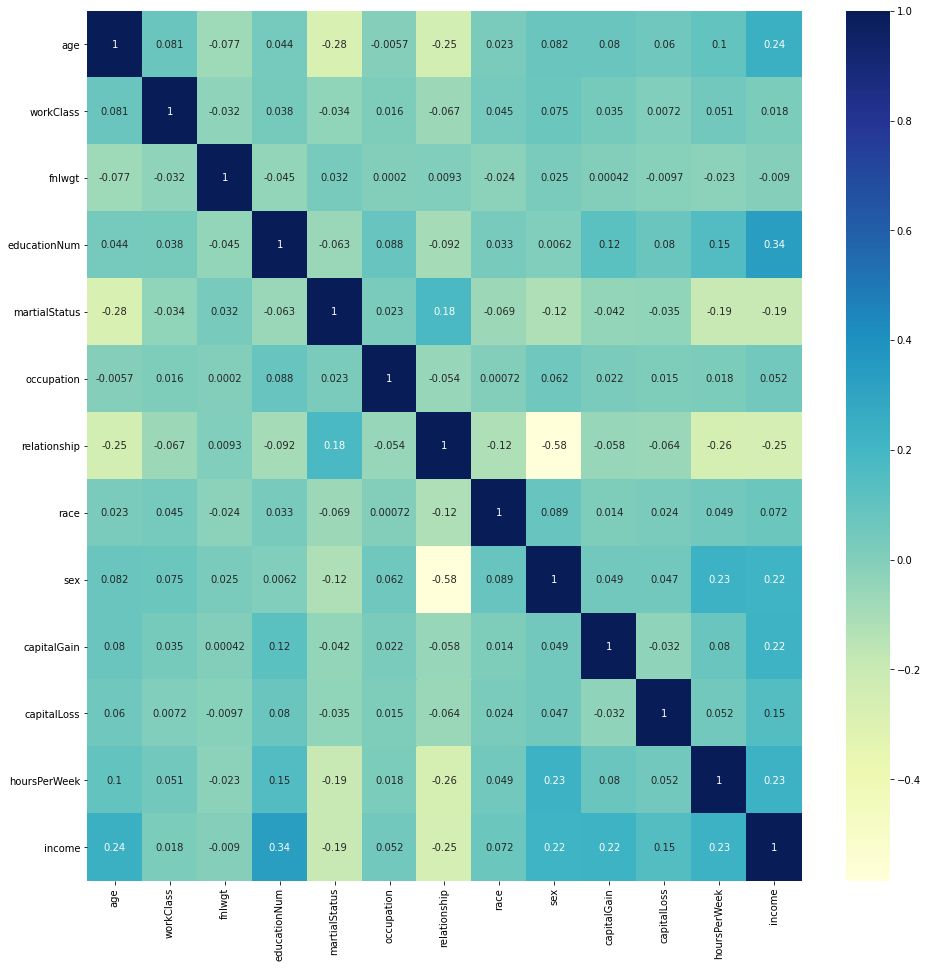

In [16]:
train_corr = train.corr()

plt.figure(figsize=(16,16))
seaborn.heatmap(train_corr,cmap='YlGnBu',annot=True)

可以看到，去除重复属性后，余下属性并不存在严重的共线性情况，所以无需据此舍弃属性。但是数据探索部分提到的部分属性应当予以移除：

In [17]:
train = train.drop(['fnlwgt'],axis=1)
test = test.drop(['fnlwgt'],axis=1)

In [18]:
train['nativeCountry'] = train['nativeCountry'].apply(lambda x: 0 if x == " United-States" else 1)
test['nativeCountry'] = test['nativeCountry'].apply(lambda x: 0 if x == " United-States" else 1)

## 数据标准化

针对连续型数据，由于各属性取值范围各不相同，为降低对后续模型选择中取值范围差异造成的影响，对连续性数据进行0-1标准化处理。这样得到的数据是无量纲的。

In [19]:
trainC = train.iloc[:,[0,2,8,9,10]]
trainC = (trainC - trainC.min())/(trainC.max()-trainC.min())
train.iloc[:,[0,2,8,9,10]] = trainC
testC = test.iloc[:,[0,2,8,9,10]]
testC = (testC - testC.min())/(testC.max()-testC.min())
test.iloc[:,[0,2,8,9,10]] = testC

## 数据保存

In [20]:
train.to_csv('./data/adult.proc.data',index=False)
test.to_csv('./data/adult.proc.test',index=False)
import json
f = open("./data/idx2label.json", "w")
json.dump([idx2label],f,indent=4)
f.close()

# 分类模型Models

### 准备：读取并分割数据集

在上一节已经处理好了数据集，由于所给训练集和测试集数量都很大，且样本类别没有出现极度不均衡的现象，所以可以从训练数据中分割出训练集和验证集，用于模型训练和评估便于优化，而原测试集可以用于最终的表现评价。

因为训练集数量很大，所以可以采用K折交叉验证的方式进行模型训练。基本思路就是将样本分割为$k$份，选取$k-1$份为训练集，$1$份为验证集进行交叉模型训练。

In [21]:
train = pd.read_csv('./data/adult.proc.data')
test = pd.read_csv('./data/adult.proc.test')
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

In [22]:
from sklearn.model_selection import StratifiedKFold

N = 5 # 5折交叉验证
skf = StratifiedKFold(n_splits=N,random_state=101,shuffle=True)

相比于使用`KFold()`，使用`StratifiedKFold()`可以保证每次分割样本的类别分布与整体一致。

## 决策树DT

### Baseline

In [23]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [24]:
print('Train Accuracy: %.5f' % clf.score(x_train,y_train))

Train Accuracy: 0.97490


In [25]:
print('Test Accuracy: %.5f' % clf.score(x_test,y_test))

Test Accuracy: 0.80219


In [26]:
y = clf.predict(x_test)

In [27]:
print(pd.DataFrame(y,columns=['income']).groupby(by=['income']).size())

income
0    11489
1     3571
dtype: int64


基本的交叉熵决策树预测模型可以达到0.79的准确率，这一数值接近`<=50k`的占比75%，查看分类结果发现预测比例较为正常。结合训练集接近1.00的得分可以判断出baseline出现了过拟合的情况，后续可展开优化。

### 优化Ⅰ：剪枝

决策树对训练集过拟合的情况很有可能是决策树深度过深，一般而言，决策树层数较少时会出现欠拟合现象，而层数过多时会出现过拟合现象。

In [28]:
clf.tree_.max_depth

45

我们一共有10个属性，32561个样本（$2^{15}=32768$），但是决策树深度来到了45层，可能对连续属性或多值离散属性进行了过多的分化。

面对决策树过拟合严重的问题，可以采用剪枝的方法，在sklearn中可以通过限定`max_depth`来进行剪枝。下面结合分层KFold测试不同深度下决策树的表现。

In [29]:
%%time
train_score = []; val_score = []; train_f1 = []; val_f1 = []
from sklearn.metrics import f1_score
MAX = clf.tree_.max_depth
for i in range(1,MAX):
    ts = 0; vs = 0; tf = 0; vf = 0
    for train_idx,val_idx in skf.split(x_train.values, y_train.values):
        clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
        clf.fit(x_train.values[train_idx],y_train.values[train_idx])
        ts += clf.score(x_train.values[train_idx],y_train.values[train_idx])
        vs += clf.score(x_train.values[val_idx],y_train.values[val_idx])
        tf += f1_score(y_train,clf.predict(x_train),pos_label=0)
        vf += f1_score(y_test,clf.predict(x_test),pos_label=0)
    train_score.append(ts/N) #取每折结果的均值作为该参数下模型表现
    val_score.append(vs/N)
    train_f1.append(tf/N)
    val_f1.append(vf/N)

CPU times: user 21.1 s, sys: 140 ms, total: 21.3 s
Wall time: 21.3 s


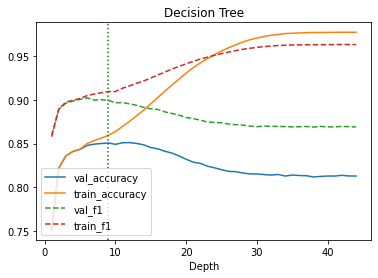

In [30]:
plt.figure()
plt.title('Decision Tree')
plt.plot(range(1,MAX),val_score,label='val_accuracy')
plt.plot(range(1,MAX),train_score,label='train_accuracy')
plt.plot(range(1,MAX),val_f1, '--', label='val_f1')
plt.plot(range(1,MAX),train_f1,'--',label='train_f1')
plt.axvline(x=9 , color='green' , linestyle=':')
plt.xlabel('Depth')
plt.legend()

观察图形可知，深度大于9时，验证集准确率达最大值0.850，随后开始下降，所以9附近应该是最佳深度，增加深度会导致模型过拟合。样本总量在32561，处于$2^{14}$和$2^{15}$之间，所以这个深度也是较为合适的。

In [31]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=9)
clf.fit(x_train,y_train)
clf.score(x_train,y_train)

0.8588621444201313

In [32]:
pred0 = clf.predict(x_test)
clf.score(x_test,y_test)

0.8403718459495352

优化剪枝后模型在测试集上的准确率为0.841,相比于baseline提升了0.05。

### 优化Ⅱ：集成学习

也可以采用集成学习的方法，将决策树桩（每颗决策树深度均为1）作为基分类器，训练多个弱分类器决策树桩，再使用加性模型得到强学习器。

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
%%time
train_score = []; val_score = []
ts = 0; vs = 0; tf = 0; vf = 0
for train_idx,val_idx in skf.split(x_train.values, y_train.values):
    clf1 = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='entropy',max_depth=1), n_estimators=200, random_state=0)
    clf1.fit(x_train.values[train_idx],y_train.values[train_idx].ravel())
    ts += clf1.score(x_train.values[train_idx],y_train.values[train_idx].ravel())
    vs += clf1.score(x_train.values[val_idx],y_train.values[val_idx].ravel())
    tf += f1_score(y_train,clf1.predict(x_train),pos_label=0)
    vf += f1_score(y_test,clf1.predict(x_test),pos_label=0)

CPU times: user 22.3 s, sys: 8.3 ms, total: 22.4 s
Wall time: 22.4 s


In [35]:
print('Train Accuracy:\t %.5f' % float(ts/N))
print('Val Accuracy:\t %.5f' % float(vs/N))
print('Train F1:\t %.5f' % float(tf/N))
print('Val F1:\t\t %.5f' % float(vf/N))

Train Accuracy:	 0.86476
Val Accuracy:	 0.86387
Train F1:	 0.91258
Val F1:		 0.90594


In [36]:
clf1.score(x_test,y_test)

0.8521912350597609

设定基分类器数量上限为200的情况下，训练集、验证集准确率超过了86.5%。验证集准确率则在85.5%。


## K近邻KNN

### Baseline

在预处理部分，我将连续型数据进行了无量纲标准化，knn计算距离时就可以避免量纲和取值范围的影响；而对于离散型数据，我采用的是整数编码，保存为整数。一般而言，KNN对离散型数据的计算应该进行类别比较，即属性取值相同时该轴距离为0，否则距离为1，所以这里需要对离散型数据追加处理，采用One-Hot编码的方式。

独热编码后，总列数增加了，运算规模变大，但是对于原来的每个离散属性而言，取值不同对距离的贡献并没有增加，还是1，因为非关键位取值为0.

In [37]:
x_train.iloc[:,[1,3,4,5,6,7]] = x_train.iloc[:,[1,3,4,5,6,7]].astype(str)
x_train_oh = pd.get_dummies(x_train)
x_test.iloc[:,[1,3,4,5,6,7]] = x_test.iloc[:,[1,3,4,5,6,7]].astype(str)
x_test_oh = pd.get_dummies(x_test)

In [38]:
from sklearn import neighbors

clf2 = neighbors.KNeighborsClassifier()
clf2.fit(x_train_oh,y_train)

KNeighborsClassifier()

In [39]:
print('Train Accuracy: %.5f' % clf2.score(x_train_oh,y_train))
print('Test Accuracy: %.5f'  % clf2.score(x_test_oh,y_test))

Train Accuracy: 0.87255
Test Accuracy: 0.81793


模型在测试集的表现大约为0.818，略优于决策树baseline，而且这里的过拟合现象没有决策树严重，因为决策树baseline（默认参数）没有限定深度，而KNN的默认参数是限定了`n_neighbors`为5.

### 优化：调整最大近邻数

In [40]:
%%time
train_score = []; val_score = []; train_f1 = []; val_f1 = []
for i in range(5,101,5):
    ts = 0; vs = 0; tf = 0; vf = 0
    for train_idx,val_idx in skf.split(x_train.values, y_train.values):
        clf2 = neighbors.KNeighborsClassifier(n_neighbors=i)
        clf2.fit(x_train_oh.values[train_idx],y_train.values[train_idx])
        ts += clf2.score(x_train_oh.values[train_idx],y_train.values[train_idx])
        vs += clf2.score(x_train_oh.values[val_idx],y_train.values[val_idx])
        tf += f1_score(y_train.values[train_idx],clf2.predict(x_train_oh.values[train_idx]),pos_label=0)
        vf += f1_score(y_train.values[val_idx],clf2.predict(x_train_oh.values[val_idx]),pos_label=0)
    train_score.append(ts/N) #取每折结果的均值作为该参数下模型表现
    val_score.append(vs/N)
    train_f1.append(tf/N)
    val_f1.append(vf/N)

CPU times: user 58min 13s, sys: 19min 46s, total: 1h 17min 59s
Wall time: 1h 3min 22s


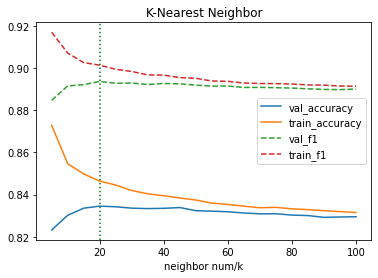

In [41]:
plt.figure()
plt.title('K-Nearest Neighbor')
plt.plot(range(5,101,5),val_score,label='val_accuracy')
plt.plot(range(5,101,5),train_score,label='train_accuracy')
plt.plot(range(5,101,5),val_f1, '--', label='val_f1')
plt.plot(range(5,101,5),train_f1,'--',label='train_f1')
plt.axvline(x=20 , color='green' , linestyle=':')
plt.xlabel('neighbor num/k')
plt.legend()

由图中的多次实验可知，k=20时验证集准确率为最高，达0.835，之后增大k会减轻模型过拟合现象，但验证集准确率并没有明显提升，所以可以判定k=20时模型可取最佳。

k较小，模型可能对部分噪声点敏感，而k较大时近邻可能包含了其他的类。

In [42]:
clf2 = neighbors.KNeighborsClassifier(n_neighbors=20)
clf2.fit(x_train_oh,y_train)
print('Train Accuracy: %.5f' % clf2.score(x_train_oh,y_train))
print('Test Accuracy: %.5f'  % clf2.score(x_test_oh,y_test))

Train Accuracy: 0.84762
Test Accuracy: 0.83293


测试集准确率大约在0.833，相比于baseline提升了0.015

## 支持向量机SVM

### Baseline

In [43]:
from sklearn.svm import SVC

clf3 = SVC()
clf3.fit(x_train_oh,y_train)
clf3.score(x_train_oh,y_train)

0.8372123864465221

In [44]:
clf3.score(x_test_oh,y_test)

0.8363877822045153

支持向量机的baseline（默认参数）准确率稍高，测试集准确率来到了0.836；但是由于经one-hot处理后数据集维度较多、数据量较大，支持向量机收敛时间也相应提升了。

### 优化：调整惩罚参数

错误项的惩罚系数。C越大，即对分错样本的惩罚程度越大，因此在训练样本中准确率越高，但是泛化能力降低，也就是对测试数据的分类准确率降低。相反，减小C的话，容许训练样本中有一些误分类错误样本，泛化能力强。

In [45]:
%%time
train_score = []; val_score = []; train_f1 = []; val_f1 = []
for i in range(1,10):
    ts = 0; vs = 0; tf = 0; vf = 0
    for train_idx,val_idx in skf.split(x_train.values, y_train.values):
        clf3 = SVC(C=i)
        clf3.fit(x_train_oh.values[train_idx],y_train.values[train_idx])
        ts += clf3.score(x_train_oh.values[train_idx],y_train.values[train_idx])
        vs += clf3.score(x_train_oh.values[val_idx],y_train.values[val_idx])
        tf += f1_score(y_train.values[train_idx],clf3.predict(x_train_oh.values[train_idx]),pos_label=0)
        vf += f1_score(y_train.values[val_idx],clf3.predict(x_train_oh.values[val_idx]),pos_label=0)
    train_score.append(ts/N) #取每折结果的均值作为该参数下模型表现
    val_score.append(vs/N)
    train_f1.append(tf/N)
    val_f1.append(vf/N)

CPU times: user 1h 11min 17s, sys: 8.64 s, total: 1h 11min 26s
Wall time: 1h 11min 29s


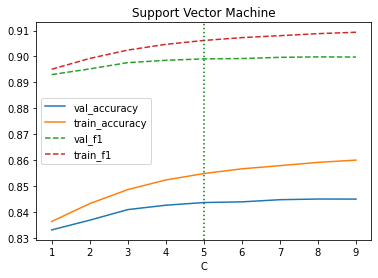

In [46]:
plt.figure()
plt.title('Support Vector Machine')
plt.plot(range(1,10),val_score,label='val_accuracy')
plt.plot(range(1,10),train_score,label='train_accuracy')
plt.plot(range(1,10),val_f1, '--', label='val_f1')
plt.plot(range(1,10),train_f1,'--',label='train_f1')
plt.axvline(x=5 , color='green' , linestyle=':')
plt.xlabel('C')
plt.legend()

由图可以看出，随着C的增大，模型准确率在上升，但当C超过5时，训练集准确率上升速度明显超过验证集，验证集准确率上升迟缓，这说明模型有过拟合倾向，泛化能力减弱。所以可以选取C=5作为较佳参数。

In [47]:
clf3 = SVC(C=5.0)
clf3.fit(x_train_oh,y_train)
print('Train Accuracy: %.5f' % clf3.score(x_train_oh,y_train))
print('Test Accuracy: %.5f'  % clf3.score(x_test_oh,y_test))

Train Accuracy: 0.85468
Test Accuracy: 0.84814


测试集准确率达到了0.848，相比baseline提升了0.012左右。

### 优化：尝试不同核函数

SVM的最优化过程中，会使用核技巧，即通过一个非线性变换，将输入空间对应于一个特征空间，使得在输入空间中的超曲面模型对应于特征空间中的超平面模型，这样可以在一定程度上缓解线性不可分问题，提升准确率。

默认参数下，SVC指定的核函数为`rbf`，即高斯核函数$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\exp\left(-\dfrac{||\boldsymbol{x}_i-\boldsymbol{x}_j||^2}{2\sigma^2}\right)$，在设定惩罚参数不变的情况下，可以尝试不同的核函数：

* `linear` 线性核函数$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\boldsymbol{x}_i^T\boldsymbol{x}_j$ 
* `poly` 多项式核函数$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=(\boldsymbol{x}_i^T\boldsymbol{x}_j)^d$
* `sigmoid` sigmoid核函数$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\tanh{(\beta\boldsymbol{x}_i^T\boldsymbol{x}_j+\theta)}$
* `precomputed` 核矩阵

In [48]:
%%time
kernels = ['rbf','linear','poly','sigmoid']
train_score = []; val_score = []; train_f1 = []; val_f1 = []
for ker in kernels:
    ts = 0; vs = 0; tf = 0; vf = 0
    for train_idx,val_idx in skf.split(x_train.values, y_train.values):
        clf3 = SVC(C=5.0,kernel=ker)
        clf3.fit(x_train_oh.values[train_idx],y_train.values[train_idx])
        ts += clf3.score(x_train_oh.values[train_idx],y_train.values[train_idx])
        vs += clf3.score(x_train_oh.values[val_idx],y_train.values[val_idx])
        tf += f1_score(y_train.values[train_idx],clf3.predict(x_train_oh.values[train_idx]),pos_label=0)
        vf += f1_score(y_train.values[val_idx],clf3.predict(x_train_oh.values[val_idx]),pos_label=0)
    train_score.append(ts/N) #取每折结果的均值作为该参数下模型表现
    val_score.append(vs/N)
    train_f1.append(tf/N)
    val_f1.append(vf/N)

CPU times: user 20min 7s, sys: 3.15 s, total: 20min 10s
Wall time: 20min 11s


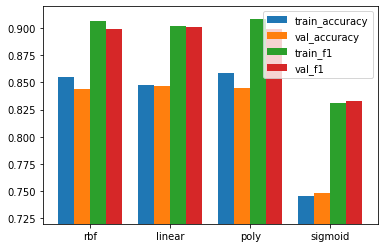

In [49]:
x = np.arange(4);total_width, n = 0.8, 4
width = total_width/n ; x=x-(total_width-width)/2
plt.xticks(x+width*1.5,kernels)
plt.ylim([0.72,0.92])
plt.bar(x,train_score,width=width,label='train_accuracy')
plt.bar(x+width,val_score,width=width,label='val_accuracy')
plt.bar(x+width*2,train_f1,width=width,label='train_f1')
plt.bar(x+width*3,val_f1,width=width,label='val_f1')
plt.legend()

由图可知，`rbf`、`linear`、`poly`三种核函数表现优于`sigmoid`，其中`poly`整体有轻微优势，故选为最终最佳核函数。

In [50]:
clf3 = SVC(C=5.0,kernel='poly',probability=True)
clf3.fit(x_train_oh,y_train)
print('Train Accuracy: %.5f' % clf3.score(x_train_oh,y_train))
print('Test Accuracy: %.5f'  % clf3.score(x_test_oh,y_test))

Train Accuracy: 0.85707
Test Accuracy: 0.84675


# 模型评价Evaluation

## 测度指标（precision, recall, f1-score）

综合上面的最终参数调整，进行模型表现评估

In [51]:
from sklearn.metrics import classification_report

print("决策树:\n",classification_report(y_test, clf.predict(x_test),digits=4))
print("Adaboost（决策树桩）:\n",classification_report(y_test, clf1.predict(x_test),digits=4))
print("K近邻:\n",classification_report(y_test, clf2.predict(x_test_oh),digits=4))
print("支持向量机:\n",classification_report(y_test, clf3.predict(x_test_oh),digits=4))

决策树:
               precision    recall  f1-score   support

           0     0.8581    0.9446    0.8993     11360
           1     0.7537    0.5203    0.6156      3700

    accuracy                         0.8404     15060
   macro avg     0.8059    0.7325    0.7574     15060
weighted avg     0.8324    0.8404    0.8296     15060

Adaboost（决策树桩）:
               precision    recall  f1-score   support

           0     0.8774    0.9347    0.9051     11360
           1     0.7492    0.5989    0.6657      3700

    accuracy                         0.8522     15060
   macro avg     0.8133    0.7668    0.7854     15060
weighted avg     0.8459    0.8522    0.8463     15060

K近邻:
               precision    recall  f1-score   support

           0     0.8638    0.9242    0.8930     11360
           1     0.7037    0.5527    0.6191      3700

    accuracy                         0.8329     15060
   macro avg     0.7838    0.7385    0.7561     15060
weighted avg     0.8245    0.8329    0.8257  

汇总加权平均值，得到下图：

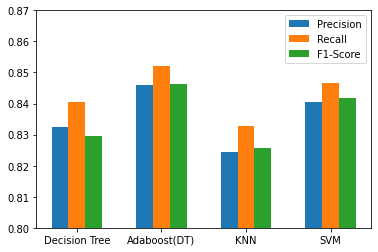

In [55]:
x = np.arange(4);total_width, n = 0.8, 4
width = total_width/n ; x=x-(total_width-width)/2
ticks = ['Decision Tree','Adaboost(DT)','KNN','SVM']
f1sc = [0.8296,0.8463,0.8257,0.8417]
reca = [0.8404,0.8522,0.8329,0.8467]
pres = [0.8324,0.8459,0.8245,0.8404]

plt.xticks(x+width,ticks)
plt.ylim([0.80,0.87])
plt.bar(x,pres,width=width,label='Precision')
plt.bar(x+width,reca,width=width,label='Recall')
plt.bar(x+width*2,f1sc,width=width,label='F1-Score')
plt.legend()

综合以上图表数据可知，从precision、recall、f1score评价指标的角度而言，经过优化的四种分类器在人口数据集上表现均尚可，其中Adaboost（决策树桩基）、SVM的性能要略胜于决策树和K近邻。

## ROC & AUC

ROC两轴分别为真正例率核假正例率，曲线越接近左上角，对应模型的分类效果越好。AUC时ROC曲线线下面积，衡量了样本预测的排序质量。

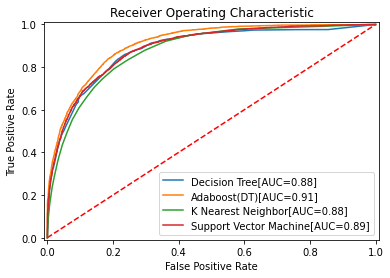

In [58]:
from sklearn.metrics import roc_curve,auc
def plot_roc(model,label,x_test):
    fpr, tpr, _ = roc_curve(y_test,model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr,tpr)
    label = label + '[AUC=%0.2f]' % roc_auc
    plt.plot(fpr,tpr,label=label)
    
plt.title('Receiver Operating Characteristic')  
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate') 
plt.xlim([-0.01, 1.01]) ; plt.ylim([-0.01, 1.01]) 
plt.plot([0, 1], [0, 1],'r--')
plot_roc(clf,'Decision Tree',x_test)
plot_roc(clf1,'Adaboost(DT)',x_test)
plot_roc(clf2,'K Nearest Neighbor',x_test_oh)
plot_roc(clf3,'Support Vector Machine',x_test_oh)
plt.legend()

从ROC曲线可以看出，四个经优化的模型均有较好的表现，且表现较为接近，这也可以由接近的AUC值进一步验证。由曲线包围情况可以得出的性能大致排名为：Adaboost（决策树桩基）、SVM、决策树、K近邻。

## PR曲线

PR曲线的横纵坐标分别为准确率和召回率，曲线越靠近右上角分类器表现越好。

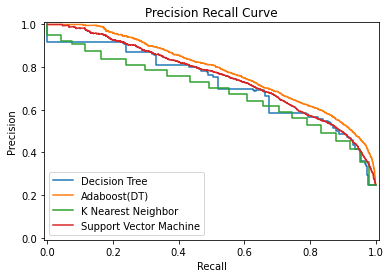

In [59]:
from sklearn.metrics import precision_recall_curve

def plot_pr(model,label,x_test):
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.step(recall,precision,label=label,where='post')

plt.title('Precision Recall Curve')  
plt.ylabel('Precision');plt.xlabel('Recall') 
plt.xlim([-0.01, 1.01]) ; plt.ylim([-0.01, 1.01]) 
plot_pr(clf,'Decision Tree',x_test)
plot_pr(clf1,'Adaboost(DT)',x_test)
plot_pr(clf2,'K Nearest Neighbor',x_test_oh)
plot_pr(clf3,'Support Vector Machine',x_test_oh)
plt.legend()

由PR曲线也可判断出四个经优化的分类器性能表现尚可，且近似，性能排名顺序同上。

## 训练时间比较

使用JupyterLab的超级命令`%%time`对部分代码块运行时间进行了统计，但是由于这些代码块的参数尝试次数不同，需要进行简单计算后进行比较：

|                 | 记录运行时   | 试参轮数 | 实际每轮训练运行时 | 特殊处理           |
| --------------- | ------------ | -------- | ------------------ | ------------------ |
| 决策树          | 21.3s        | 45       | 0.473s             |                    |
| Adaboost        | 22.4s        | 1        | 22.4s              | 200个基学习器      |
| K近邻           | 1h 3min 22s  | 20       | 190.1s             | 训练集独热，47属性 |
| 支持向量机(rbf) | 1h 11min 29s | 9        | 476.5s             | 训练集独热，47属性 |

这里的每轮训练是完成一次完整的5折交叉验证训练，调用一次`fit()`，两次`score()`，两次`predict()`，分别处理训练集和验证集。

由于要适应模型特点，K近邻和支持向量机的输入须独热处理，耗时较长。但是实际上，四者性能接近，表现最优的Adaboost实际耗时并不是最长的，但是比剪枝的决策树要略长；rbf作为核函数的支持向量机的训练时间最长，但是表现要优于同样数据独热处理的k近邻。

所以，选择模型时，要综合模型性能、数据量选择“性价比”较高的模型。

# 实验总结Summary

1. 完成了本次实验要求，完整进行了数据探索、数据处理、模型选择与评价过程，完成了对美国人口普查数据集的一次二分类数据挖掘任务。感觉数据挖掘任务的一个非常重要的环节是数据预处理，这一步需要充分掌握数据的特点，对数据进行合适的处理，数据质量将在很大程度上影响模型的表现。
2. 使用4种模型完成分类任务，就本次任务而言，四者模型性能表现均优良，这可能得益于数据量较为充分，数据质量高，类别分布未出现不均匀情况。
3. 根据模型的不同计算特点，对部分模型的输入数据进行了追加独热处理，独热处理后计算距离更为科学，但是也增大了计算量。`sklearn`包不支持GPU加速运算，所以在训练上较为耗时。我对部分属性进行了优化，例如国家属性有40个可能取值，独热编码后也就有40个列向量；但是90%的样本该值均为美国，所以我将其简化为二值属性：美国0/非美国1，减少了维度。
4. 实验的不足：可以进行特征选择或降维，如上一点中提到的国家属性，这个属性应该由于方差较小被剔除（虽然二值化保留了更多信息），更多的属性可以通过PCA降维等融合为一个属性，这样可以减少计算量，加快运行速度。